<a href="https://colab.research.google.com/github/salmanromeo/1D_Pitching_Moment/blob/main/PINN_Noise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
# Libraries
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

In [12]:
def save_gif_PIL(outfile, files, fps=5, loop=0):
    imgs = [Image.open(file) for file in files]
    imgs[0].save(fp=outfile, format='GIF', append_images=imgs[1:], save_all=True, duration=int(1000/fps), loop=loop)

In [13]:
# Defines the analytical solution

def oscillator(A, ro, v, s, d, CM_q_a, CM_a, I, phi, t):
    w = np.sqrt(-((ro*v**2*s*d*CM_a)/(2*I)))    # w is omega
    cos = torch.cos(w*t + phi)
    e = (ro*v*s*d**2)*(CM_q_a)/(8*I)            # e is epsilon
    exp = torch.exp(e*t)
    y  = A*exp*cos                              # y is alpha
    return y

In [14]:
# Defines a standard fully-connected network in PyTorch

class FCN(nn.Module):

    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)
        
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

In [16]:
# Main
A       = 1
ro      = 1.20
v       = 858
s       = 0.00385
d       = 0.07
CM_q_a  = 0.15            # CM_q_a  = np.array([0.15, 0, -0.171, -0.342])
CM_a    = -0.09
I       = 1.55e-4
phi     = 0
sig_0_5 = 0.5
sig_1   = 1

In [18]:
# get the analytical solution over the full domain
t = torch.linspace(0,0.3,300).view(-1,1)                           # time from 0 to 0.1
y = oscillator(A, ro, v, s, d, CM_q_a, CM_a, I, phi, t).view(-1,1)
yn_0_5 = y + np.random.uniform(-sig_0_5,sig_0_5,t.shape)
yn_1 = y + np.random.uniform(-sig_1,sig_1,t.shape) 
print(t.shape, y.shape)

torch.Size([300, 1]) torch.Size([300, 1])


torch.Size([150, 1]) torch.Size([150, 1])


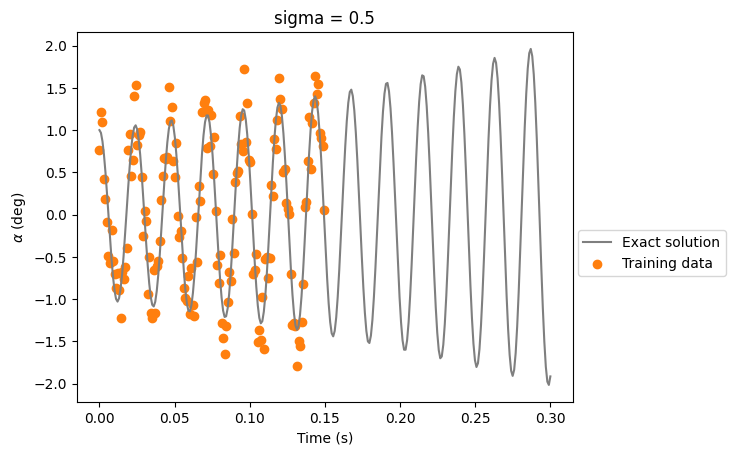

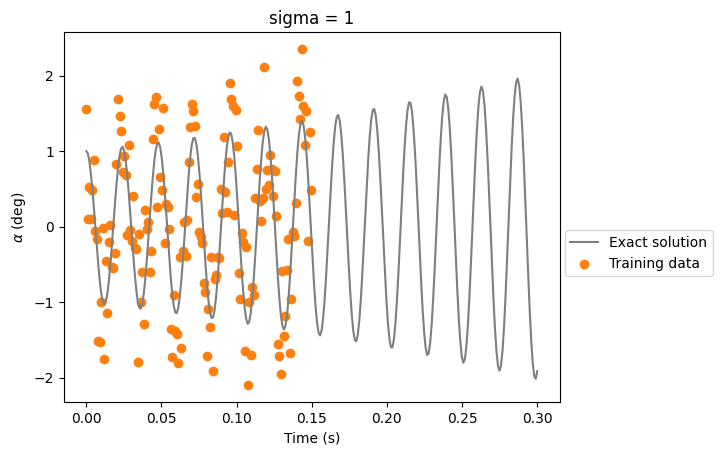

In [19]:
# slice out a small number of points from the LHS of the domain
t_data = t[0:150:1]   # time data 
y_datan_0_5 = yn_0_5[0:150:1]   # alpha data
y_datan_1 = yn_1[0:150:1]   # alpha data
print(t_data.shape, y_datan.shape)

plt.figure()
plt.plot(t, y, label="Exact solution", color="tab:grey")
plt.scatter(t_data, y_datan_0_5, color="tab:orange", label="Training data")
plt.legend(loc=(1.01,0.34))
plt.title("sigma = 0.5")
plt.xlabel("Time (s)")
plt.ylabel(r'$\alpha$ (deg)')
plt.show()

plt.figure()
plt.plot(t, y, label="Exact solution", color="tab:grey")
plt.scatter(t_data, y_datan_1, color="tab:orange", label="Training data")
plt.legend(loc=(1.01,0.34))
plt.title("sigma = 1")
plt.xlabel("Time (s)")
plt.ylabel(r'$\alpha$ (deg)')
plt.show()

In [20]:
def plot_result(t,y,t_data,y_data,yh,xp=None):

    plt.figure()
    plt.plot(t,y, color="grey", linewidth=2, alpha=0.8, label="Exact solution")
    plt.plot(t,yh, color="tab:green", linewidth=4, alpha=0.8, label="PINN solution")
    plt.scatter(t_data, y_datan, s=60, color="tab:orange", alpha=0.4, label='Noisy training data')
    if xp is not None:
        plt.scatter(xp, -0*torch.ones_like(xp), s=60, color="tab:green", alpha=0.4, 
                    label='Collocation points')
    l = plt.legend(loc=(1.01,0.34), frameon=False, fontsize="xx-large")
    plt.setp(l.get_texts(), color="k")
    plt.title(f"Training step {i}")
    plt.xlabel("Time (s)")
    plt.ylabel(r'$\alpha$ (deg)')
    plt.axis("on")

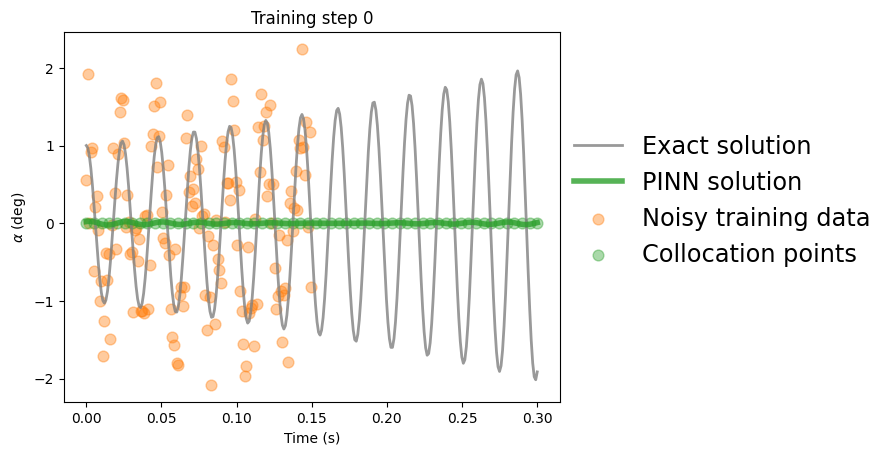

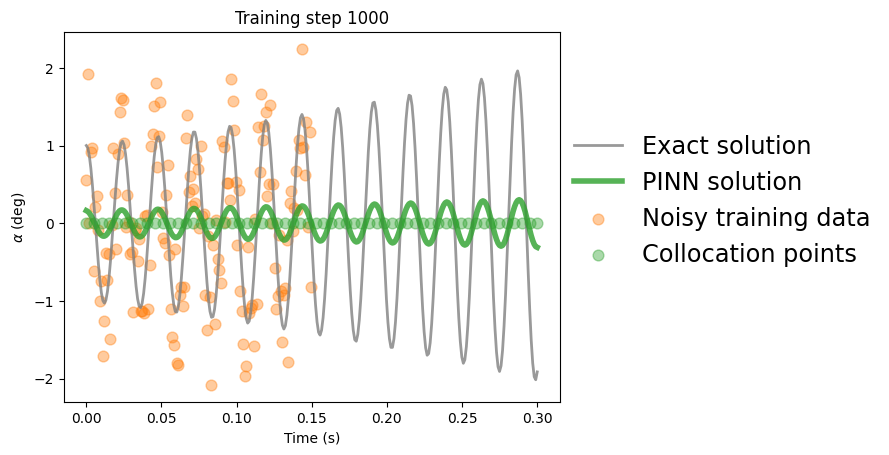

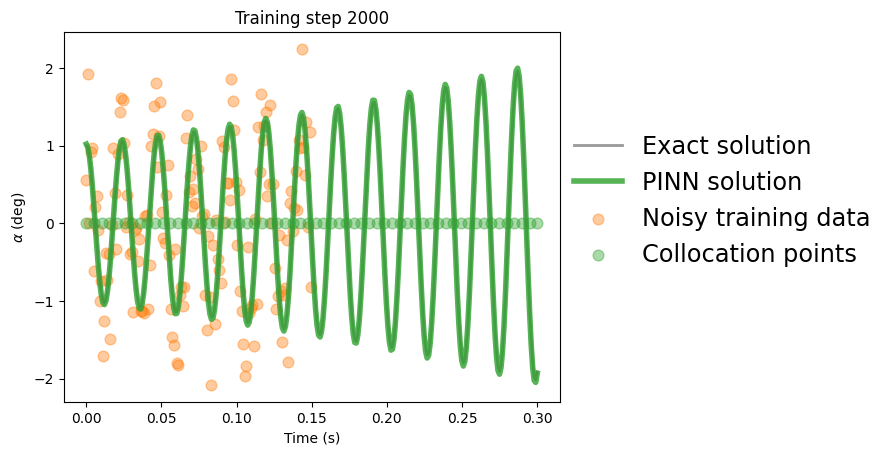

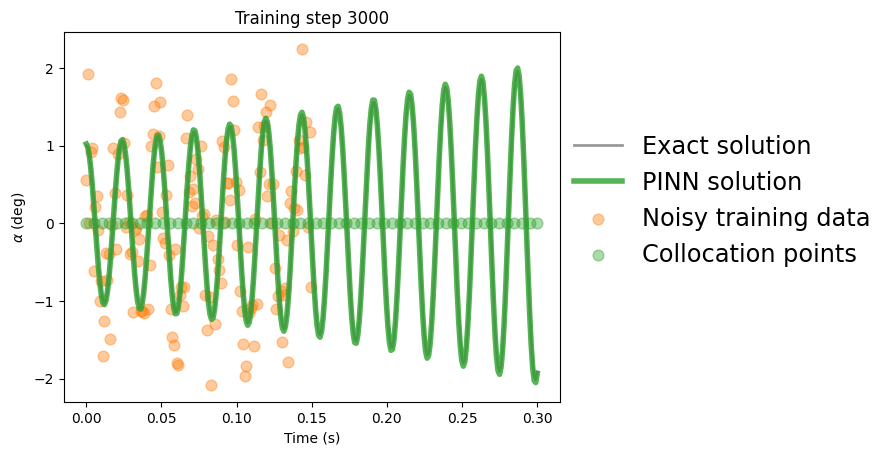

In [21]:
t_physics = torch.linspace(0,0.3,60).view(-1,1).requires_grad_(True) # sample locations over the problem domain
mu = -((ro*v*s*d**2)*(CM_q_a)/(4*I))   # mu is the coefficient ahead alpha_dot
k = -((ro*v**2*s*d*CM_a)/(2*I))        # k is the coefficient ahead alpha

torch.manual_seed(123)
model = FCN(1,1,32,3)

# define additional a,b learnable parameters in the ansatz
# TODO: write code here
a = torch.nn.Parameter(260*torch.ones(1, requires_grad=True))
b = torch.nn.Parameter(torch.ones(1, requires_grad=True))

optimizer = torch.optim.Adam(list(model.parameters())+[a,b],lr=1e-3)   # learning rate = 1e-2
files = []
for i in range(4000):                                     # epochs = 3000
    optimizer.zero_grad()

    # compute the "data loss"
    yh_0_5 = model(t_data)*torch.sin(a*t_data+b)
    loss1 = torch.mean((yh_0_5-y_datan_0_5)**2)                     # use mean squared error
    
    # compute the "physics loss"
    yhp = model(t_physics)*torch.sin(a*t_physics+b)
    dt  = torch.autograd.grad(yhp, t_physics, torch.ones_like(yhp), create_graph=True)[0]     # computes dy/dx
    dt2 = torch.autograd.grad(dt,  t_physics, torch.ones_like(dt),  create_graph=True)[0]     # computes d^2y/dx^2
    physics = dt2 + mu*dt + k*yhp                                                             # computes the residual of the 1D harmonic oscillator differential equation
    loss2 = (0.6e-5)*torch.mean(physics**2)
    
    # backpropagate joint loss
    loss = loss1 + loss2                                   # add two loss terms together
    loss.backward()
    optimizer.step()
    
    # plot the result as training progresses
    if (i) % 1000 == 0: 
        
        yh_0_5 = (model(t)*torch.sin(a*t+b)).detach()
        xp = t_physics.detach()
        
        plot_result(t,y,t_data,y_datan_0_5,yh_0_5,xp)
        
        file = "/content/sample_data/plots/S_h_pinn_%.8i.png"%(i+1)
        plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
        files.append(file)
        
        if (i) % 1000 == 0: plt.show()
        else: plt.close("all")
            
save_gif_PIL("S_h_pinn.gif", files, fps=5, loop=0)

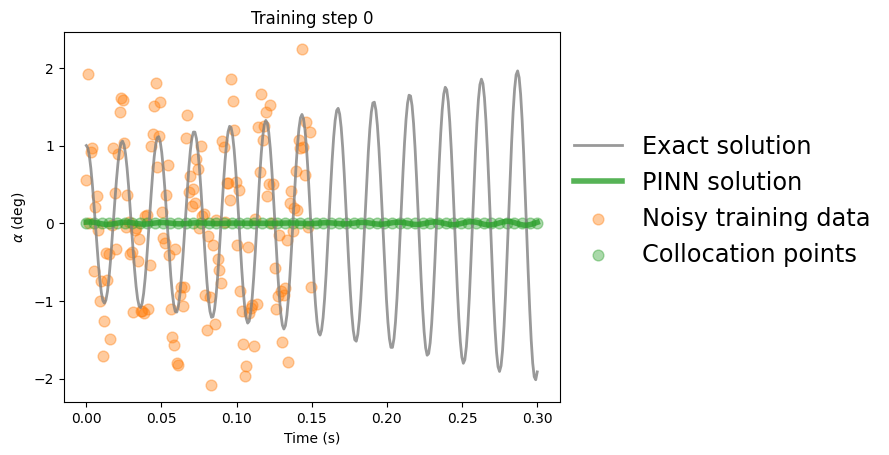

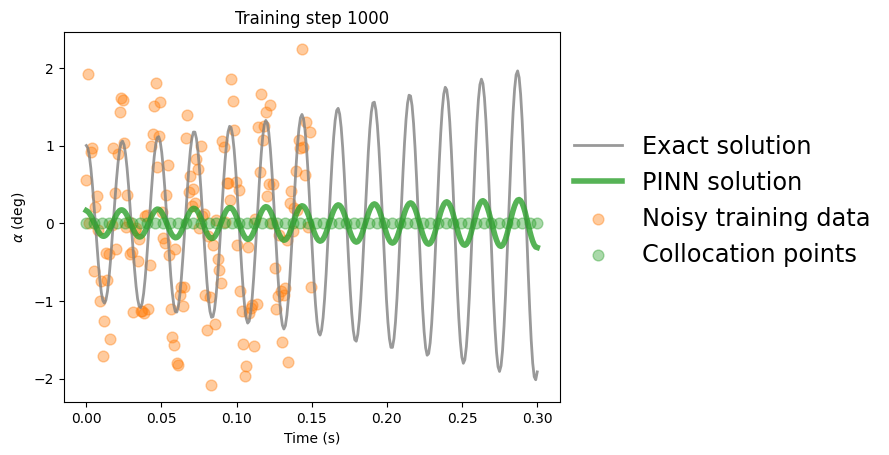

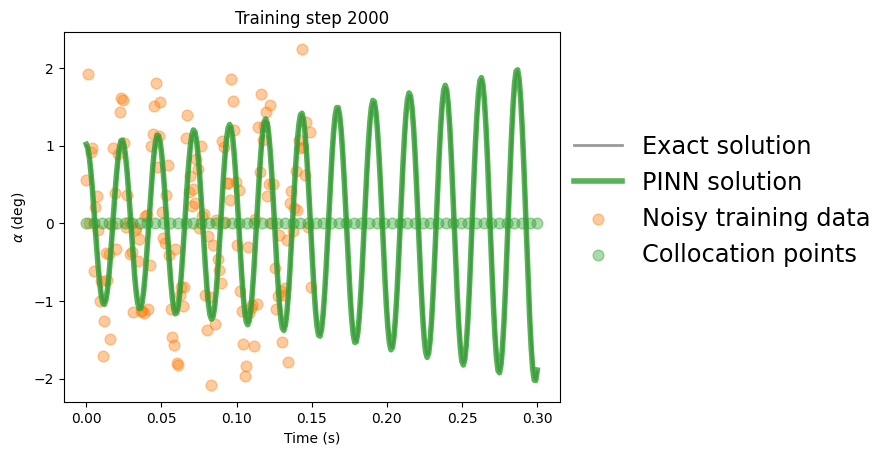

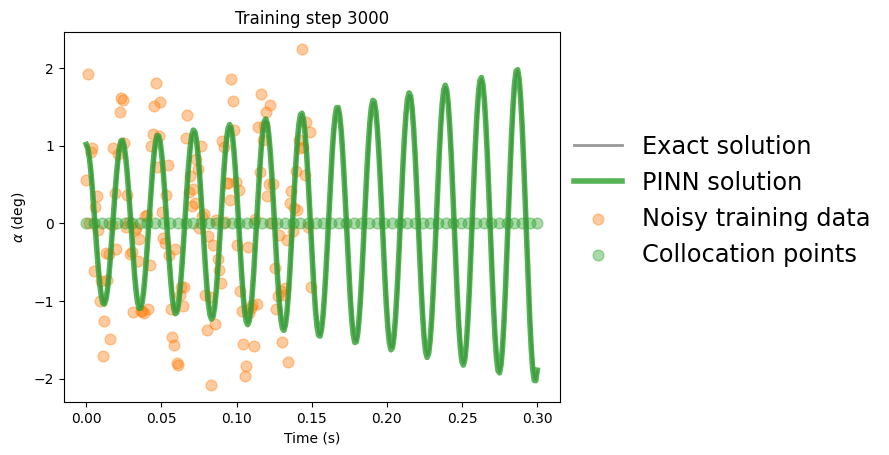

In [23]:
t_physics = torch.linspace(0,0.3,60).view(-1,1).requires_grad_(True) # sample locations over the problem domain
mu = -((ro*v*s*d**2)*(CM_q_a)/(4*I))   # mu is the coefficient ahead alpha_dot
k = -((ro*v**2*s*d*CM_a)/(2*I))        # k is the coefficient ahead alpha

torch.manual_seed(123)
model = FCN(1,1,32,3)

# define additional a,b learnable parameters in the ansatz
# TODO: write code here
a = torch.nn.Parameter(260*torch.ones(1, requires_grad=True))
b = torch.nn.Parameter(torch.ones(1, requires_grad=True))

optimizer = torch.optim.Adam(list(model.parameters())+[a,b],lr=1e-3)   # learning rate = 1e-2
files = []
for i in range(4000):                                     # epochs = 3000
    optimizer.zero_grad()

    # compute the "data loss"
    yh_1 = model(t_data)*torch.sin(a*t_data+b)
    loss1 = torch.mean((yh_1-y_datan_1)**2)                     # use mean squared error
    
    # compute the "physics loss"
    yhp = model(t_physics)*torch.sin(a*t_physics+b)
    dt  = torch.autograd.grad(yhp, t_physics, torch.ones_like(yhp), create_graph=True)[0]     # computes dy/dx
    dt2 = torch.autograd.grad(dt,  t_physics, torch.ones_like(dt),  create_graph=True)[0]     # computes d^2y/dx^2
    physics = dt2 + mu*dt + k*yhp                                                             # computes the residual of the 1D harmonic oscillator differential equation
    loss2 = (0.6e-5)*torch.mean(physics**2)
    
    # backpropagate joint loss
    loss = loss1 + loss2                                   # add two loss terms together
    loss.backward()
    optimizer.step()
    
    # plot the result as training progresses
    if (i) % 1000 == 0: 
        
        yh_1 = (model(t)*torch.sin(a*t+b)).detach()
        xp = t_physics.detach()
        
        plot_result(t,y,t_data,y_datan_1,yh_1,xp)
        
        file = "/content/sample_data/plots/S_h_pinn_%.8i.png"%(i+1)
        plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
        files.append(file)
        
        if (i) % 1000 == 0: plt.show()
        else: plt.close("all")
            
save_gif_PIL("S_h_pinn.gif", files, fps=5, loop=0)